<a href="https://colab.research.google.com/github/qli111/QSAR-COVID-19/blob/main/Virtual_Screening_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 44.9 MB/s eta 0:00:00


In [3]:
import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

In [4]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification', model_dir="/content/model_dir")
    return model

In [5]:
dataset_file = "/content/dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

In [6]:
splitter = dc.splits.RandomSplitter()

In [7]:
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In [8]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10
for i in tqdm(range(0,cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(733,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(733, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(3242,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16:0", shape=(3242, 64), dtype=float32), dense_s

[0.5924380262765028, 0.6699316003971373, 0.8982559874067145, 0.8228368852646348, 0.8233492402196935, 0.876094368390309, 0.3782572874980047, 0.7779570338785654, 0.7559859237827792, 0.7757224931028601]
[0.3508647326336185, 0.7047972264664374, 0.7040189638958985, 1.0, 0.6518011356977635, 0.7032364358565029, 0.3131324768399919, 0.7729109291165613, 0.7534545402108427, 0.6720564364567376]


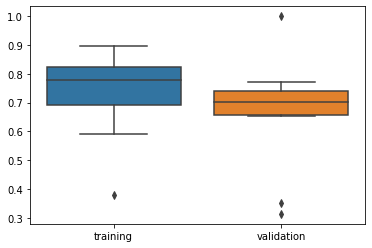

In [9]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

In [10]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [11]:
pred

[array([0.97597784, 0.02402214], dtype=float32),
 array([0.99454695, 0.00545311], dtype=float32),
 array([9.990891e-01, 9.109358e-04], dtype=float32),
 array([0.99126136, 0.00873859], dtype=float32),
 array([0.9967437 , 0.00325632], dtype=float32),
 array([0.9988898 , 0.00111031], dtype=float32),
 array([0.9939594, 0.0060406], dtype=float32),
 array([0.9878275 , 0.01217244], dtype=float32),
 array([9.9962860e-01, 3.7142404e-04], dtype=float32),
 array([9.9971533e-01, 2.8473532e-04], dtype=float32),
 array([0.9776278 , 0.02237216], dtype=float32),
 array([0.16870877, 0.8312912 ], dtype=float32),
 array([0.99493617, 0.00506385], dtype=float32),
 array([0.97280526, 0.02719476], dtype=float32),
 array([9.9971831e-01, 2.8174705e-04], dtype=float32),
 array([0.99144155, 0.00855837], dtype=float32),
 array([0.37721214, 0.6227879 ], dtype=float32),
 array([0.9975009 , 0.00249911], dtype=float32),
 array([0.8551134 , 0.14488667], dtype=float32),
 array([0.99687296, 0.0031271 ], dtype=float32),


In [12]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

In [13]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [14]:
pred_df.head()

,neg,pos,active,SMILES
0,0.975978,0.024022,0,CC1=C(CN2Cc3ccccc3OC3(CCN(CC4=c5ccncc5=NC4)CC3...
1,0.994547,0.005453,0,Cc1ccc(cc1NC(=O)N[C@@H](c2ccc(cc2)OC)C3CC3)NC(...
2,0.999089,0.000911,0,CC1=C([C@H](NC(=S)N1)c2ccc(cc2)O)C(=O)N/N=C/c3...
3,0.991261,0.008739,0,COC(=O)c1c2c(sc1NC(=O)CCSc3nnc(n3N)c4ccccc4O)C...
4,0.996744,0.003256,0,c1cc(c(cc1NS(=O)(=O)c2ccc3c(c2)[nH]c(=O)[nH]3)...


In [15]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
11,0.168709,0.831291,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
51,0.224174,0.775826,1,CNC(=O)c1c2c(n(n1)C)-c3c(cnc(n3)NC4CCN(CC4)C(=...
37,0.242673,0.757327,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCCc4...
45,0.348649,0.651351,1,CC1CNC(=O)c2c1c3cc(ccc3[nH]2)C(=O)Nc4cccnc4
16,0.377212,0.622788,0,c1ccc(cc1)[C@@]2(CCN(C2)c3c(ncc(n3)c4cc[nH]n4)N)O
290,0.593046,0.406954,0,c1c2c([nH]n1)nc(nc2N3CCC4(CC3)C(=O)N=C(N4)C5CC5)N
95,0.652636,0.347364,0,Cc1cc(c2c(c1)nc(c(=O)[nH]2)NC(=S)N)C
300,0.691353,0.308647,0,c1ccc(cc1)[C@H]2CCCN(CC2)c3ccc4nnc(n4n3)C(F)(F)F
137,0.748601,0.251399,0,c1ccc(cc1)c2nc([nH]n2)CN3c4ccccc4N[C@@H]3C5CC5
187,0.756580,0.243420,1,CCNC(=O)Nc1ccc(cn1)CNc2c(scn2)C(=O)Nc3ccc4c(c3...


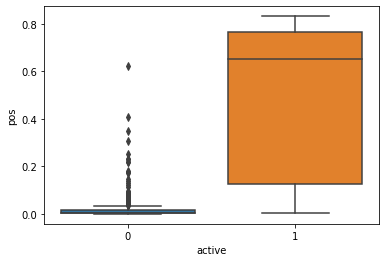

In [16]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)

In [17]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

In [18]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")

,neg,pos,active,SMILES,Mol
93,0.995831,0.004169,1,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,
187,0.756580,0.243420,1,CCNC(=O)Nc1ccc(cn1)CNc2c(scn2)C(=O)Nc3ccc4c(c3...,
233,0.997482,0.002518,1,COc1cc2c(cc1OCCCN3CCOCC3)ncc(c2Nc4ccc(cc4)Oc5c...,

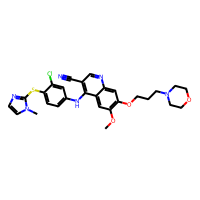
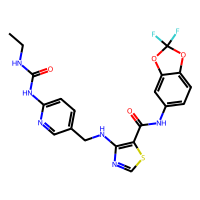
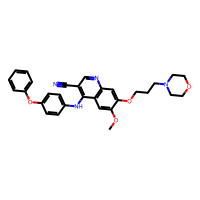

In [19]:
false_negative_df

In [20]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")

,neg,pos,active,SMILES,Mol
16,0.377212,0.622788,0,c1ccc(cc1)[C@@]2(CCN(C2)c3c(ncc(n3)c4cc[nH]n4)N)O,

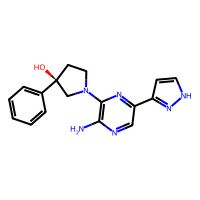

In [21]:
false_positive_df

In [22]:
model.fit(dataset)

0.0012495492895444233

In [27]:
model.save()

NotImplementedError: ignored